In [15]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_community.tools import TavilySearchResults
from langchain_community.agent_toolkits import create_sql_agent, SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec
from langchain_openai import OpenAIEmbeddings
from langchain.agents import AgentType, initialize_agent
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

import os

In [16]:
# Initialize model
model = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


In [17]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


In [10]:
from langchain_core.tools import tool


pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index = pc.Index('agent-hackathon')
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
db = SQLDatabase.from_uri("sqlite:///db/product_demo.db")


In [12]:
sql_toolkit = SQLDatabaseToolkit(db=db, llm=model)

web_search = TavilySearchResults(
        max_results=5,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
        # include_domains=[...],
        # exclude_domains=[...],
        # name="...",            # overwrite default tool name
        # description="...",     # overwrite default tool description
        # args_schema=...,       # overwrite default args_schema: BaseModel
    )

yh_tools = [YahooFinanceNewsTool()]

In [13]:
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")  
system_message = prompt_template.format(dialect="SQLite", top_k=5) 

sql_agent = create_react_agent(
    model=model, 
    name='sql_agent',
    tools=sql_toolkit.get_tools(),
    prompt=system_message
)

rag_agent = create_react_agent(model, [retrieve], name="rag_agent")

yh_agent = create_react_agent(
    name="yh_agent",
    model=model,
    tools=yh_tools,
)


# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, sql_agent, yh_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a sql expert connected to a product database and a rag agent that has information on an article LLM Powered Autonomous Agents."
        "For current events, use research_agent. "
        "For learning about products from database use sql_agent."
        "For questions on the LLM Powered Autonomous Agents paper use rag_agent."
    )
)

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

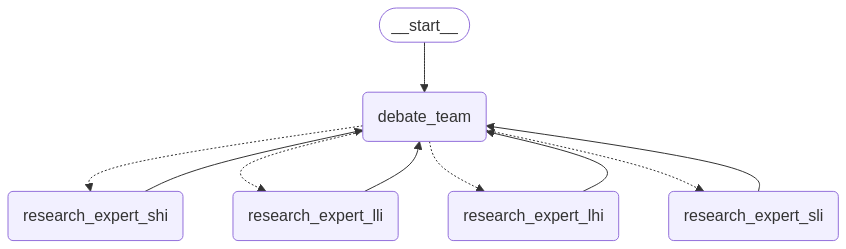

In [ ]:
# Long-Term, Low-Risk Investor (Conservative Wealth Builder)  
agent_lli = create_react_agent(
    model=model,
    tools=[],
    name="research_expert_lli",
    prompt="As an AI financial assistant for a long-term, low-risk investor,"
    "your goal is to recommend stable and reliable investment options with a"
    "strong history of steady growth and minimal volatility. "
    "Using the given data, you have to"
    "Focus on blue-chip stocks,"
    "ETFs, and dividend-paying companies with solid fundamentals. Prioritize assets with low debt,"
    "high profitability, and a strong competitive moat. Avoid speculative stocks, volatile assets,"
    "and high-risk investments. Analyze historical performance, financial statements,"
    "and macroeconomic trends before making recommendations."
    "Example Investments:"
    " - S&P 500 ETFs (VOO, VTI)"
    " - Dividend Aristocrats (JNJ, KO, PG)"
    " - Government Bonds & REITs"
)

agent_lhi = create_react_agent(
    model=model,
    tools=[],
    name="research_expert_lhi",
    prompt="Long-Term, High-Risk Investor (Growth-Oriented)"
    "As an AI financial advisor for a long-term, high-risk investor,"
    "focus on identifying companies and sectors with high growth potential."
    "Using the given data, you have to"
    "Analyze disruptive technologies, AI, biotech, and innovative startups."
    "Evaluate revenue growth rates, scalability, and market trends to suggest investments."
    "While risk is acceptable, prioritize companies with a competitive edge, strong management,"
    "and long-term sustainability. Consider future trends like AI, renewable energy, and blockchain."
    "Provide risk assessments, but allow for high volatility investments."
    "Example Investments:"
    " - Growth Stocks (NVDA, TSLA, AMZN)"
    " - AI & Tech Startups"
    " - Cryptocurrencies & Blockchain ETFs"
)

agent_sli = create_react_agent(
    model=model,
    tools=[],
    name="research_expert_sli",
    prompt="Short-Term, Low-Risk Investor (Safe Trader)"
    "As an AI trading assistant for a short-term, low-risk investor,"
    "Using the given data,"
    "your task is to identify safe, short-term opportunities with low volatility."
    "Focus on short-term bonds, defensive stocks, and index fund ETFs."
    "Use market trend analysis to find steady assets that provide predictable,"
    "low-risk returns within a 6-month to 2-year horizon. Avoid speculative trades and highly volatile stocks."
    "Incorporate macroeconomic indicators such as interest rates and inflation trends into investment decisions."
    "Example Investments:"
    " - Short-Term Treasury Bonds (SHY, BIL)"
    " - Defensive Stocks (Consumer Staples, Healthcare)"
    " - Low-Volatility ETFs"
)

agent_shi = create_react_agent(
    model=model,
    tools=[],
    name="research_expert_shi",
    prompt="Short-Term, High-Risk Investor (Aggressive Trader)."
    "As an AI trading assistant for a short-term, high-risk investor,"
    "your goal is to find high-potential short-term trades with significant upside."
    "Use technical indicators like RSI, MACD, and moving averages to identify breakout stocks and"
    "momentum trades. Prioritize high-volatility sectors such as tech, biotech, and"
    "cryptocurrencies. Incorporate market sentiment analysis, earnings reports, and"
    "macroeconomic news to optimize trade timing. Suggest risk management strategies,"
    "including stop-loss and position sizing."
    "Example Investments:"
    " - Meme Stocks & IPOs"
    " - High-Beta Growth Stocks (Tesla, Palantir)"
    " - Crypto & Options Trading"
)


# Create supervisor workflow
workflow = create_supervisor(
    [agent_lli, agent_lhi, agent_sli, agent_shi],
    model=model,
    supervisor_name="debate_team",
    prompt=(
        "You are a team supervisor managing a panel of financial investment research experts. "
        "Your team consists of four specialized agents: "
        "1. agent_lli - Long-Term, Low-Risk Investor (Conservative Wealth Builder): Focuses on stable and reliable investment options with minimal volatility. "
        "2. agent_lhi - Long-Term, High-Risk Investor (Growth-Oriented): Identifies high growth potential companies and sectors, accepting higher risk for higher returns. "
        "3. agent_sli - Short-Term, Low-Risk Investor (Safe Trader): Identifies safe, short-term opportunities with low volatility. "
        "4. agent_shi - Short-Term, High-Risk Investor (Aggressive Trader): Finds high-potential short-term trades with significant upside, using technical indicators and market sentiment analysis. "
        "Your goal is to leverage the expertise of each agent to provide comprehensive investment recommendations."
        "Consider the input from each agent, analyze their suggestions, and synthesize a balanced investment strategy that aligns with the client's risk tolerance and investment horizon."
        )
)

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is the standard method for Task Decomposition based on the LLM Powered Autonomous Agents paper? vs what's on the internet?"
        }
    ]
})

In [ ]:
result

{'messages': [HumanMessage(content="What is the standard method for Task Decomposition based on the LLM Powered Autonomous Agents paper? vs what's on the internet?", additional_kwargs={}, response_metadata={}, id='41ff5f88-16c3-44f2-acc0-00ad1fe794c2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Lb5iHCrHZw9h2q01yqn5mNhp', 'function': {'arguments': '{}', 'name': 'transfer_to_rag_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 163, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-898421fd-49b9-41bb-a6f6-0a8f6a31d22b-0', tool_calls=[{'name': 'transfer_to_ra